In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [22]:
# CSV読み込み
eac_daily = pd.read_csv("eac_daily.csv")
eac_events = pd.read_csv("eac_events.csv")

# 列確認
print("eac_daily columns:", list(eac_daily.columns))
print("eac_events columns:", list(eac_events.columns))

eac_daily columns: ['userId', 'todoId', 'dateKey', 'deadlineKey', 'estimatedMinutes', 'minutes', 'cumMinutes', 'pace7d', 'spi', 'eacDateKey', 'eacOverDeadline', 'completed', 'hasPlan', 'planContainsThisTodo', 'planAllocatedMinutes']
eac_events columns: ['userId', 'todoId', 'eventDateKey', 'deadlineKey', 'estimatedMinutes', 'eacDateKey_at_event', 'minutes_before_7d_avg', 'minutes_after_7d_avg', 'delta_minutes_7d', 'pace7d_at_event', 'spi_at_event', 'hasPlan_at_event', 'planContainsThisTodo_at_event', 'notes']


In [23]:
# ログインフラグの読み込み
login_df = pd.read_csv("daily_logins.csv")
login_df["date"] = pd.to_datetime(login_df["date"], errors="coerce")
login_df["loginFlag"] = pd.to_numeric(login_df.get("loginFlag", 0), errors="coerce").fillna(0).astype(int)
login_df["firstLoginAtJst"] = pd.to_datetime(login_df.get("firstLoginAtJst"), errors="coerce")


In [24]:
# 日付型に変換
eac_events["eventDateKey"] = pd.to_datetime(
    eac_events["eventDateKey"], errors="coerce"
)
eac_events["deadlineKey"] = pd.to_datetime(
    eac_events["deadlineKey"], errors="coerce"
)
eac_events["eacDateKey_at_event"] = pd.to_datetime(
    eac_events["eacDateKey_at_event"], errors="coerce"
)

# EACが本当に締切を超えているイベントか確認
(eac_events["eacDateKey_at_event"] > eac_events["deadlineKey"]).value_counts()


True    27
Name: count, dtype: int64

In [25]:
# ログインフラグをイベントにマージ
login_for_events = login_df.rename(columns={"date": "eventDateKey"})[["userId", "eventDateKey", "loginFlag", "firstLoginAtJst"]]
eac_events_with_login = eac_events.merge(login_for_events, on=["userId", "eventDateKey"], how="left")
eac_events_with_login["loginFlag"] = eac_events_with_login["loginFlag"].fillna(0).astype(int)
eac_events_with_login["firstLoginAtJst"] = pd.to_datetime(eac_events_with_login["firstLoginAtJst"], errors="coerce")


In [26]:
# 必要な列が揃っているか確認（保険）
needed = ["minutes_before_7d_avg", "minutes_after_7d_avg", "delta_minutes_7d"]
print("has needed cols:", {c: c in eac_events.columns for c in needed})

# 記述統計
eac_events[needed].describe()

has needed cols: {'minutes_before_7d_avg': True, 'minutes_after_7d_avg': True, 'delta_minutes_7d': True}


,minutes_before_7d_avg,minutes_after_7d_avg,delta_minutes_7d
count,27.000000,26.000000,26.000000
mean,29.386243,24.356227,-6.105311
std,37.740871,35.742290,24.149482
min,0.000000,0.000000,-60.000000
25%,4.285714,0.000000,-11.964286
50%,8.571429,5.785714,-4.642857
75%,51.428571,38.571429,-0.535714
max,142.857143,125.714286,65.714286


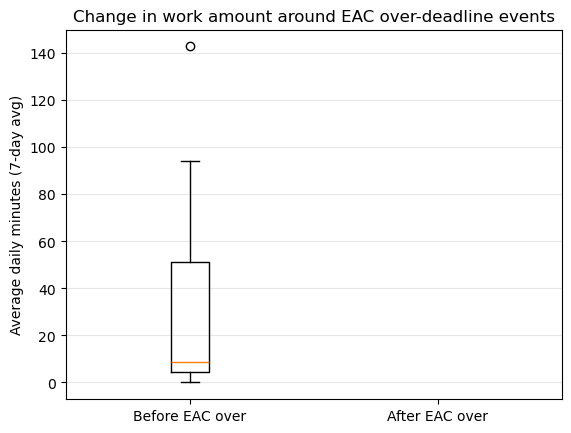

In [27]:
plt.boxplot(
    [
        eac_events["minutes_before_7d_avg"],
        eac_events["minutes_after_7d_avg"]
    ],
    tick_labels=["Before EAC over", "After EAC over"]
)

plt.ylabel("Average daily minutes (7-day avg)")
plt.title("Change in work amount around EAC over-deadline events")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [28]:
from scipy import stats

# EAC超過イベント前後の差分
delta = eac_events["delta_minutes_7d"]

# 正規性検定（Shapiro–Wilk）
stats.shapiro(delta)

ShapiroResult(statistic=nan, pvalue=nan)

In [29]:
# 対応のある t 検定（前後比較）
stats.ttest_rel(
    eac_events["minutes_before_7d_avg"],
    eac_events["minutes_after_7d_avg"]
)

TtestResult(statistic=nan, pvalue=nan, df=nan)

In [30]:
# 効果量 Cohen's d（対応あり）
diff = eac_events["minutes_before_7d_avg"] - eac_events["minutes_after_7d_avg"]
cohens_d = diff.mean() / diff.std(ddof=1)
cohens_d

0.2528133490314919

In [31]:
# 作業量が減少したイベントの割合
(eac_events["delta_minutes_7d"] < 0).mean()

0.7037037037037037

In [32]:
# ログイン有無で前後比較（平均/中央値/効果量）
def summarize_paired(df, label):
    out = {"label": label, "rows": len(df)}
    if len(df) == 0:
        out.update({
            "mean_before": np.nan,
            "median_before": np.nan,
            "mean_after": np.nan,
            "median_after": np.nan,
            "mean_delta": np.nan,
            "median_delta": np.nan,
            "cohens_d": np.nan,
        })
        return out

    before = pd.to_numeric(df["minutes_before_7d_avg"], errors="coerce")
    after = pd.to_numeric(df["minutes_after_7d_avg"], errors="coerce")
    delta = after - before
    cohens_d = delta.mean() / delta.std(ddof=1) if delta.std(ddof=1) != 0 else np.nan

    out.update({
        "mean_before": float(before.mean()),
        "median_before": float(before.median()),
        "mean_after": float(after.mean()),
        "median_after": float(after.median()),
        "mean_delta": float(delta.mean()),
        "median_delta": float(delta.median()),
        "cohens_d": float(cohens_d),
    })
    return out

comp_login = pd.DataFrame([
    summarize_paired(eac_events_with_login, "all events"),
    summarize_paired(eac_events_with_login[eac_events_with_login["loginFlag"] == 1], "login events"),
])

display(comp_login)


,label,rows,mean_before,median_before,mean_after,median_after,mean_delta,median_delta,cohens_d
0,all events,27,29.386243,8.571429,24.356227,5.785714,-6.105311,-4.642857,-0.252813
1,login events,21,31.925170,9.285714,23.080499,8.571429,-8.844671,-5.000000,-0.351406
